In [1]:
pip install pandas geopandas shapely matplotlib numpy cartopy

  Using cached pandas-2.3.3-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached shapely-2.1.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.4 MB/s eta 0:00:00
  Using cached numpy-2.3.5-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached cartopy-0.25.0-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached pyogrio-0.12.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached pyproj-3.7.2-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (31 kB)
  Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.8 MB/s eta 0:00:00
  Using 

In [2]:
# Cell 1: Imports and environment setup
import os
import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point, box
import matplotlib.pyplot as plt
import numpy as np

# Allow OGR to accept non-closed rings
os.environ["OGR_GEOMETRY_ACCEPT_UNCLOSED_RING"] = "YES"

# --- Configuration ---
base_dir = "/home/njm12/ATMS_596/Land-Water"
target_crs = "EPSG:26915"  # UTM Zone 15
tornado_csv = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv"  # Update with your CSV path
states_of_interest = ["IL", "IA", "MO"]
min_date = pd.to_datetime("2007-02-01")

In [3]:
# Cell 2: Load UMESC Mississippi River shapefiles
pool_dirs = [f"Pool {p}" for p in range(12, 27) if p != 23] + ["Open River", "Open River 2"]
gdfs = []

for pool_dir in pool_dirs:
    if "Open River" in pool_dir:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z16n83.shp"))
        local_crs = "EPSG:26916"
    else:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z15n83.shp"))
        local_crs = target_crs

    for f in shp_files:
        gdf = gpd.read_file(f)
        if gdf.crs is None:
            gdf = gdf.set_crs(local_crs)
        gdf = gdf.to_crs(target_crs)
        gdf["POOL"] = pool_dir
        gdfs.append(gdf)

umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=target_crs)
print("UMESC combined:", umesc_all.shape)

UMESC combined: (8050, 14)


In [4]:
# Cell 3: Extract Illinois water portion
url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
states = gpd.read_file(url)
illinois = states[states["NAME"] == "Illinois"].to_crs(target_crs)

# Filter water polygons only
water_only = umesc_all[umesc_all["LAND_WATER"] == "Water"].copy()
water_il = gpd.clip(water_only, illinois)

# Plot check
ax = water_il.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Illinois Water Bodies (UMESC)")
plt.show()

GEOSException: TopologyException: side location conflict at 637771.60273088841 4484529.1467366582. This can occur if the input geometry is invalid.

In [5]:
print("Number of invalid geometries in water_only:", (~water_only.is_valid).sum())
print("Invalid geometries indices:", water_only[~water_only.is_valid].index)

Number of invalid geometries in water_only: 13
Invalid geometries indices: Index([2532, 2660, 2757, 2766, 2830, 3309, 3397, 3400, 3416, 3417, 4595, 5202,
       5204],
      dtype='int64')


In [6]:
# Fix invalid geometries using buffer(0)
water_only.loc[~water_only.is_valid, "geometry"] = water_only.loc[~water_only.is_valid, "geometry"].buffer(0)

# Verify
print("Invalid geometries after fix:", (~water_only.is_valid).sum())

Invalid geometries after fix: 0


In [7]:
# Ensure Illinois geometry is valid
illinois["geometry"] = illinois["geometry"].buffer(0)

# Perform clip
water_il = gpd.clip(water_only, illinois)

print("Clipped water shapes:", water_il.shape)

Clipped water shapes: (2876, 14)


In [8]:
# Combine all Illinois water polygons into a single geometry
river_il = water_il.unary_union
print(type(river_il))
print("Bounds of Illinois river section:", river_il.bounds)

/tmp/ipykernel_318/3305131056.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_il = water_il.unary_union


<class 'shapely.geometry.multipolygon.MultiPolygon'>
Bounds of Illinois river section: (626594.3664122473, 4098437.22724262, 844182.0029604747, 4708927.272888837)


In [9]:
# Automatic date parsing
tornadoes = pd.read_csv(tornado_csv, parse_dates=['date'])

# Filter by states, EF-scale, and date
tornadoes = tornadoes[
    tornadoes['st'].isin(states_of_interest) &
    tornadoes['mag'].isin([0, 1, 2]) &
    (tornadoes['date'] >= min_date)
]

print("Filtered tornadoes:", tornadoes.shape)
print(tornadoes.head())

Filtered tornadoes: (2643, 29)
         om    yr  mo  dy       date      time  tz  st  stf  stn  ...    len  \
49298  1005  2007  10  17 2007-10-17  15:05:00   3  MO   29   34  ...   0.10   
49301  1008  2007  10  17 2007-10-17  16:46:00   3  MO   29   35  ...  10.11   
49305  1012  2007  10  17 2007-10-17  18:35:00   3  MO   29   36  ...   2.80   
49308  1015  2007  10  17 2007-10-17  22:35:00   3  MO   29   37  ...   0.10   
49309  1017  2007  10  17 2007-10-17  22:55:00   3  MO   29   39  ...   0.53   

       wid  ns  sn  sg   f1  f2  f3  f4  fc  
49298   25   1   1   1  101   0   0   0   0  
49301  150   1   1   1  109   0   0   0   0  
49305  100   1   1   1   77   0   0   0   0  
49308   35   1   1   1  105   0   0   0   0  
49309   30   1   1   1   27   0   0   0   0  

[5 rows x 29 columns]


In [10]:
# Remove any rows with missing or invalid coordinates
coord_cols = ['slon', 'slat', 'elon', 'elat']
tornadoes = tornadoes.dropna(subset=coord_cols)

# Remove out-of-bounds or unrealistic coordinates
tornadoes = tornadoes[
    (tornadoes['slon'].between(-180, 180)) &
    (tornadoes['elon'].between(-180, 180)) &
    (tornadoes['slat'].between(-90, 90)) &
    (tornadoes['elat'].between(-90, 90))
]
print("After coordinate cleaning:", tornadoes.shape)

After coordinate cleaning: (2643, 29)


In [11]:
# --- Fix 1: Convert positive longitudes (U.S. longitudes are negative west of Greenwich) ---
tornadoes['slon'] = tornadoes['slon'].apply(lambda x: -x if x > 0 else x)
tornadoes['elon'] = tornadoes['elon'].apply(lambda x: -x if x > 0 else x)

# --- Fix 2: Remove zero or missing coordinates (invalid positions) ---
tornadoes.loc[tornadoes['slat'] == 0, 'slat'] = np.nan
tornadoes.loc[tornadoes['elat'] == 0, 'elat'] = np.nan
tornadoes.loc[tornadoes['slon'] == 0, 'slon'] = np.nan
tornadoes.loc[tornadoes['elon'] == 0, 'elon'] = np.nan

# Drop rows with NaNs after cleaning
tornadoes = tornadoes.dropna(subset=['slon', 'slat', 'elon', 'elat']).copy()

# Check coordinate ranges again
print("Longitude range (fixed):", tornadoes[['slon', 'elon']].min().min(), "to", tornadoes[['slon', 'elon']].max().max())
print("Latitude range (fixed):", tornadoes[['slat', 'elat']].min().min(), "to", tornadoes[['slat', 'elat']].max().max())

Longitude range (fixed): -96.48 to -87.0264
Latitude range (fixed): 36.0022 to 43.5808


In [12]:
from shapely.geometry import LineString, Point
import geopandas as gpd

# Create LineString or Point geometries
def make_geom(row):
    if pd.isna(row['elon']) or pd.isna(row['elat']) or \
       (row['elon'] == row['slon'] and row['elat'] == row['slat']):
        return Point(row['slon'], row['slat'])
    else:
        return LineString([(row['slon'], row['slat']), (row['elon'], row['elat'])])

tornadoes['geometry'] = tornadoes.apply(make_geom, axis=1)

# Convert to GeoDataFrame
tornado_gdf = gpd.GeoDataFrame(tornadoes, geometry='geometry', crs="EPSG:4326")

# Reproject to match water shapefile CRS
tornado_gdf = tornado_gdf.to_crs(target_crs)

print("✅ Tornado geometries rebuilt")
print("Geometry types:", tornado_gdf.geometry.geom_type.value_counts())
print("Bounds:", tornado_gdf.total_bounds)

✅ Tornado geometries rebuilt
Geometry types: LineString    2471
Point          153
Name: count, dtype: int64
Bounds: [ 216476.7540067  3987738.95756939  998831.73103427 4825617.33576493]


In [13]:
# Fix invalid water polygons
water_il['geometry'] = water_il['geometry'].buffer(0)

# Merge into single geometry
river_il_geom = water_il.geometry.unary_union  # or .union_all() if using new shapely

# Ensure the final geometry is valid
from shapely.validation import make_valid
river_il_geom = make_valid(river_il_geom)

/tmp/ipykernel_318/3999912912.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_il_geom = water_il.geometry.unary_union  # or .union_all() if using new shapely


In [15]:
# Buffer by 10 km
river_buffer = river_il_geom.buffer(10000)  # adjust as needed

# Check intersections with buffer
tornado_gdf['crosses_river'] = tornado_gdf.intersects(river_buffer)
crossings = tornado_gdf[tornado_gdf['crosses_river']]

print("Total weak tornadoes crossing Mississippi River or intersecting buffered zone:", crossings.shape[0])
print("Counts by EF-scale:\n", crossings['mag'].value_counts())

Total weak tornadoes crossing Mississippi River or intersecting buffered zone: 155
Counts by EF-scale:
 mag
0    68
1    63
2    24
Name: count, dtype: int64


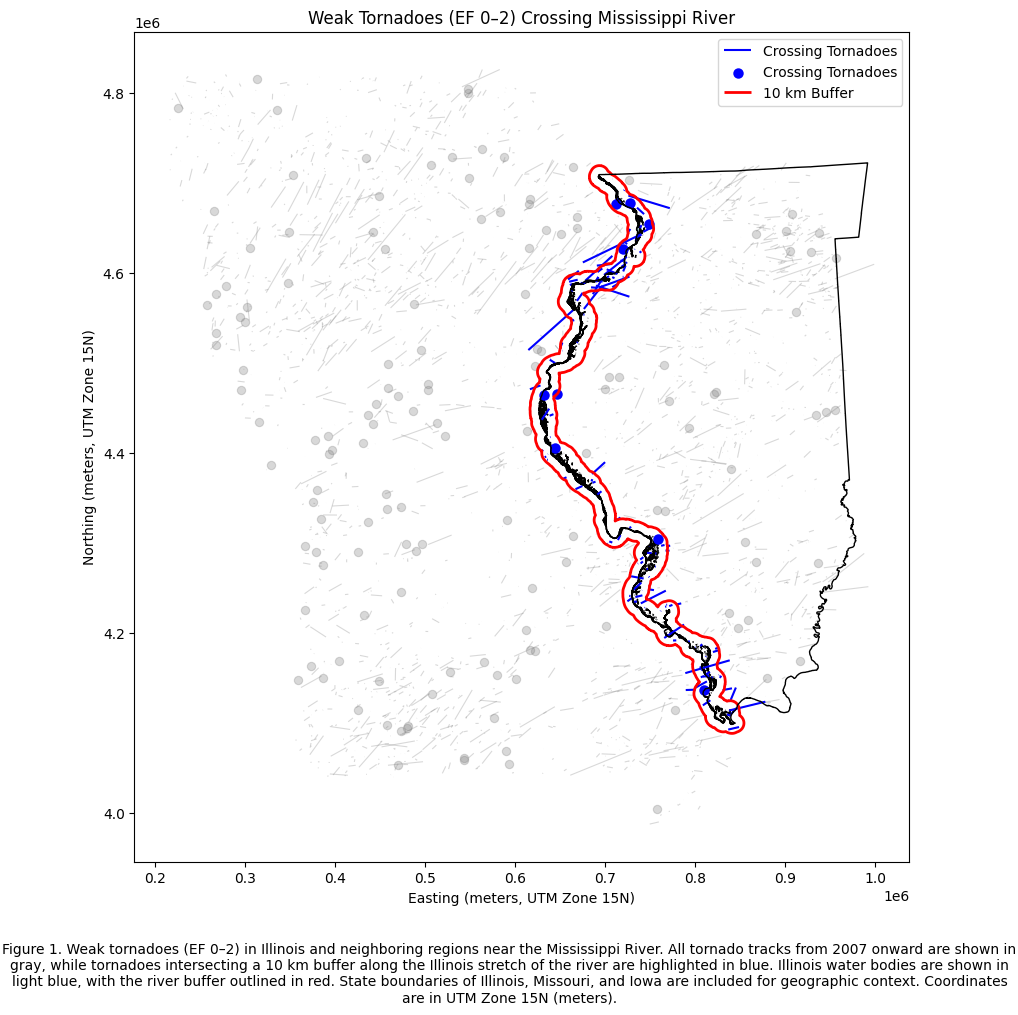

Tornado CRS: EPSG:26915
River CRS: EPSG:26915
River buffer bounds: (616595.5123264829, 4088442.1257714224, 854170.7704540391, 4718927.228456482)


In [16]:
# --- Step 5: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
crossings.plot(ax=ax, color='blue', linewidth=1.5, label='Crossing Tornadoes')
gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')
illinois.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Weak Tornadoes (EF 0–2) Crossing Mississippi River")
ax.legend()

# Axes labels with units
ax.set_xlabel("Easting (meters, UTM Zone 15N)")
ax.set_ylabel("Northing (meters, UTM Zone 15N)")


# Add figure caption at the bottom
caption = ("Figure 1. Weak tornadoes (EF 0–2) in Illinois and neighboring regions near the Mississippi River. "
           "All tornado tracks from 2007 onward are shown in gray, while tornadoes intersecting a 10 km buffer "
           "along the Illinois stretch of the river are highlighted in blue. Illinois water bodies are shown in light blue, "
           "with the river buffer outlined in red. State boundaries of Illinois, Missouri, and Iowa are included for geographic context. "
           "Coordinates are in UTM Zone 15N (meters).")
plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

print("Tornado CRS:", tornado_gdf.crs)
print("River CRS:", water_il.crs)
print("River buffer bounds:", river_buffer.bounds)

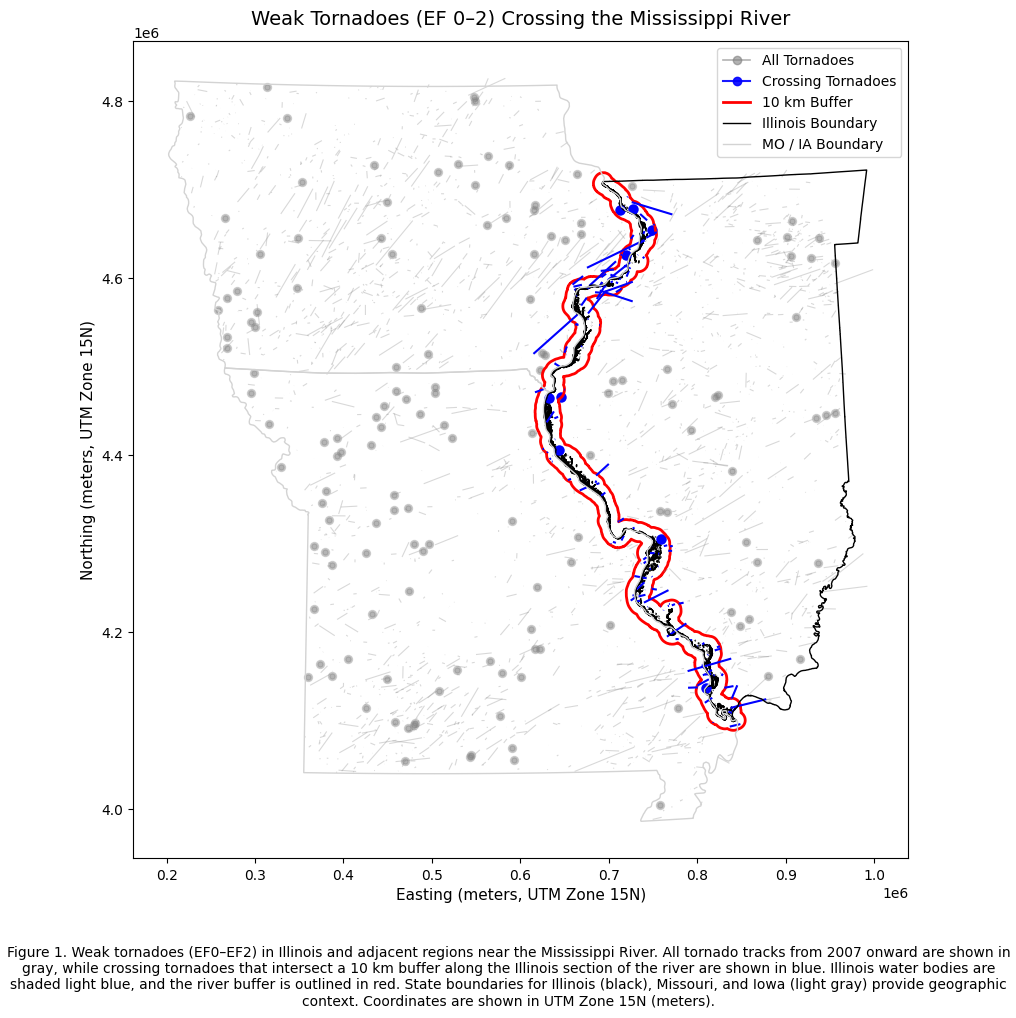

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Step 5: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))

# Plot Illinois water and river buffer
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')

# Plot all tornadoes (lines + points)
tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
tornado_gdf[tornado_gdf.geometry.geom_type == 'Point'].plot(ax=ax, color='gray', markersize=15, alpha=0.4)

# Plot crossing tornadoes (lines + points)
crossings.plot(ax=ax, color='blue', linewidth=1.5)
crossings[crossings.geometry.geom_type == 'Point'].plot(ax=ax, color='blue', markersize=25)

# Plot Illinois, Missouri, and Iowa boundaries
illinois.boundary.plot(ax=ax, color='black', linewidth=1, label='Illinois Boundary')

states_path = "/home/njm12/ATMS_596/ne_10m_admin_1_states_provinces.shp"
states = gpd.read_file(states_path).to_crs(target_crs)
states_mo_ia = states[states['name'].isin(['Missouri', 'Iowa'])]
states_mo_ia.boundary.plot(ax=ax, color='lightgray', linewidth=1, label='MO / IA Boundary')

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# --- Labels, title, and caption ---
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title("Weak Tornadoes (EF 0–2) Crossing the Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Easting (meters, UTM Zone 15N)", fontsize=11)
ax.set_ylabel("Northing (meters, UTM Zone 15N)", fontsize=11)

# Figure caption
caption = (
    "Figure 1. Weak tornadoes (EF0–EF2) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 2007 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in UTM Zone 15N (meters)."
)
plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

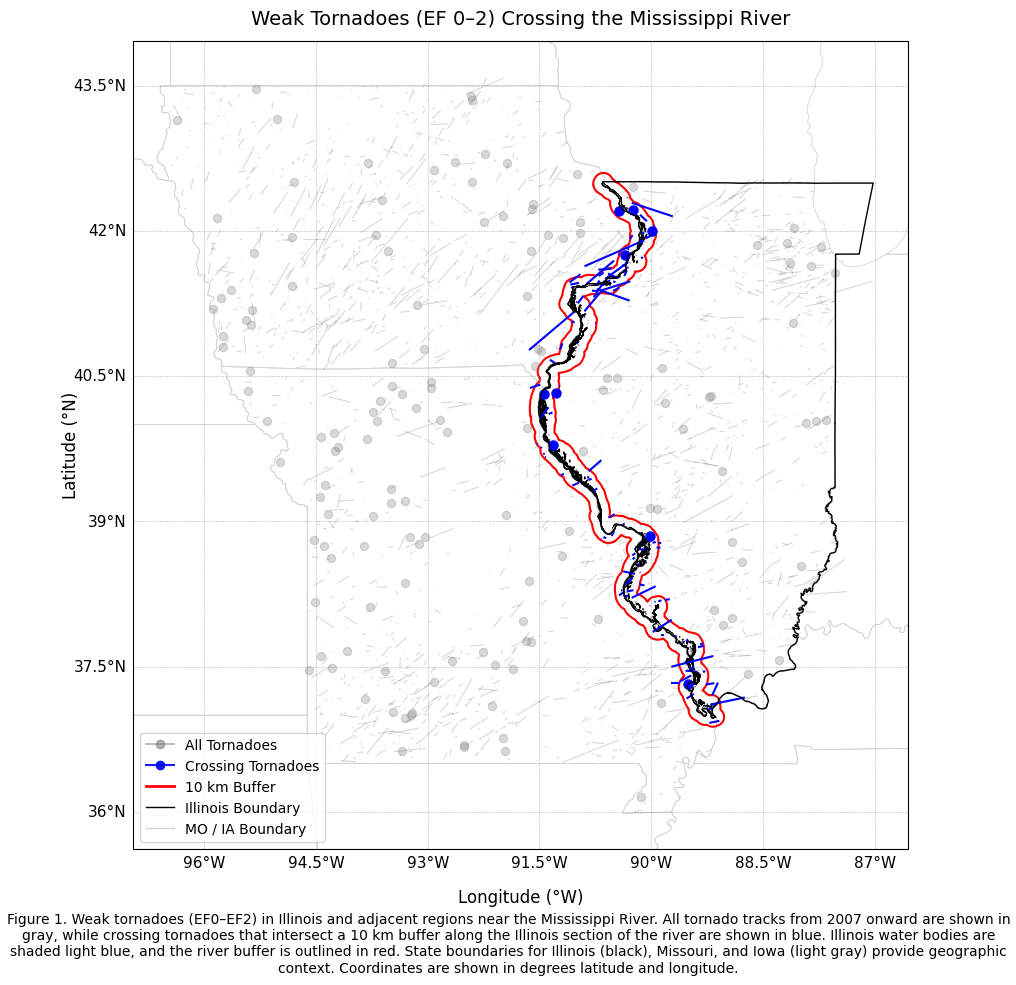

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = tornado_gdf.to_crs("EPSG:4326")
crossings_geo = crossings.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([river_buffer], crs=water_il.crs).to_crs("EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map background
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# Plot layers
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)
tornado_geo.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3, transform=ccrs.PlateCarree(), label='All Tornadoes', zorder=3)
crossings_geo.plot(ax=ax, color='blue', linewidth=1.5, transform=ccrs.PlateCarree(), label='Crossing Tornadoes', zorder=4)
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# Gridlines and coordinate labels
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# Add axis labels manually
ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# Add title and legend
ax.set_title("Weak Tornadoes (EF 0–2) Crossing the Mississippi River", fontsize=14, pad=12)
ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Caption
caption = (
    "Figure 1. Weak tornadoes (EF0–EF2) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 2007 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in degrees latitude and longitude."
)
plt.figtext(0.5, 0.12, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

/tmp/ipykernel_318/3619325141.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_il_geom = water_il.geometry.buffer(0).unary_union


Total weak tornadoes in bounding box: 0
Counts by EF-scale:
 Series([], Name: count, dtype: int64)


/tmp/ipykernel_318/3619325141.py:49: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  tornado_in_box.plot(ax=ax, color='orange', linewidth=1, label='Tornado Tracks')


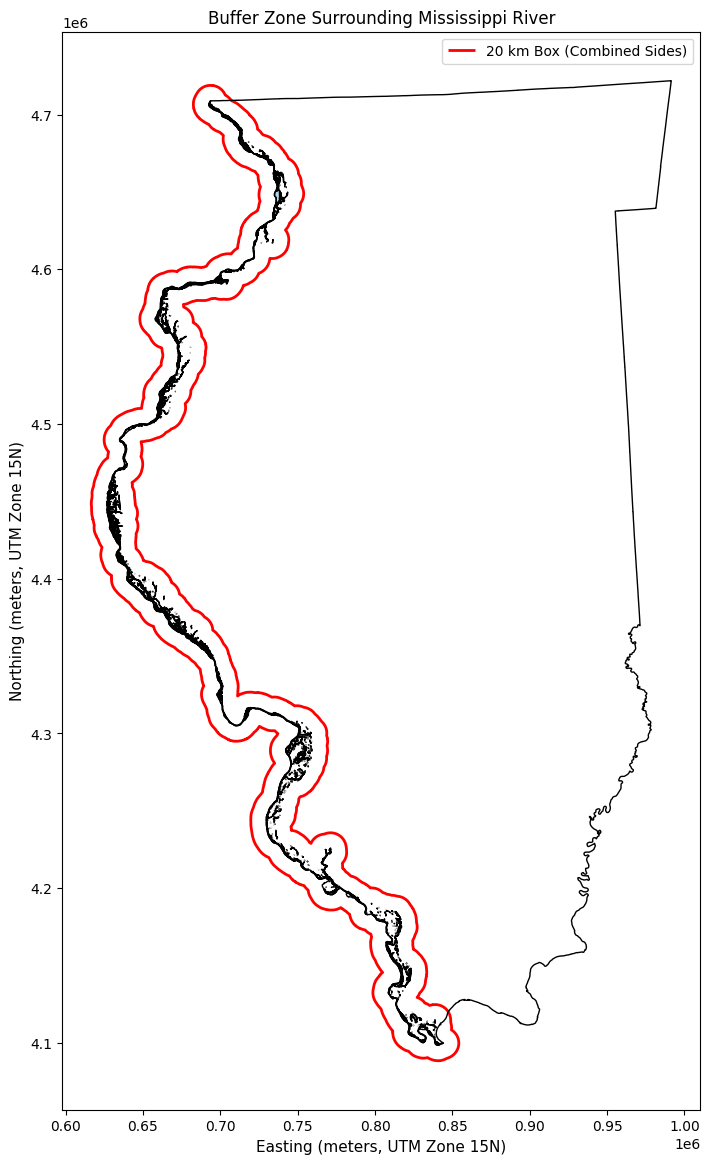

In [14]:
#Extra work: 

import geopandas as gpd
from shapely.geometry import LineString, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# --- Step 1: Ensure tornado geometries are valid ---
tornado_gdf['geometry'] = tornado_gdf['geometry'].buffer(0)

# --- Step 2: Create Mississippi River centerline along Illinois ---
# Merge water polygons and get river centerline
river_il_geom = water_il.geometry.buffer(0).unary_union

# Simplify river to line for bounding box (optional)
# If MultiPolygon, take exterior boundaries and create line
from shapely.ops import linemerge
river_lines = []
if river_il_geom.geom_type == 'MultiPolygon':
    for poly in river_il_geom.geoms:
        river_lines.append(poly.exterior)
    river_centerline = linemerge(river_lines)
else:
    river_centerline = river_il_geom.exterior

# --- Step 3: Create 20 km wide bounding box along river ---
# 10 km on either side (buffer)
buffer_distance = 10000  # meters
river_bbox = river_centerline.buffer(buffer_distance)

# Only set CRS if missing, otherwise just transform
if tornado_gdf.crs is None:
    tornado_gdf = tornado_gdf.set_crs("EPSG:4326")
tornado_gdf = tornado_gdf.to_crs(target_crs)

# --- Step 4: Filter tornadoes intersecting bounding box ---
tornado_in_box = tornado_gdf[tornado_gdf.intersects(river_bbox)]

# --- Step 5: Summed counts by EF-scale ---
ef_counts = tornado_in_box['mag'].value_counts().sort_index()
print("Total weak tornadoes in bounding box:", tornado_in_box.shape[0])
print("Counts by EF-scale:\n", ef_counts)

# --- Step 6: Plot tornado tracks and bounding box ---
fig, ax = plt.subplots(figsize=(10, 14))
# Plot Illinois water as light blue
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
# Plot tornado tracks in bounding box
tornado_in_box.plot(ax=ax, color='orange', linewidth=1, label='Tornado Tracks')
# Plot bounding box outline in red
gpd.GeoSeries([river_bbox]).boundary.plot(ax=ax, color='red', linewidth=2, label='20 km Box (Combined Sides)')
# Plot Illinois boundary
illinois.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Buffer Zone Surrounding Mississippi River")
ax.set_xlabel("Easting (meters, UTM Zone 15N)", fontsize=11)
ax.set_ylabel("Northing (meters, UTM Zone 15N)", fontsize=11)
ax.legend()
plt.show()

In [16]:
print("Tornado CRS:", tornado_gdf.crs)
print("River CRS:", water_il.crs)

print("\nTornado bounds (projected):", tornado_gdf.total_bounds)
print("River bounds (projected):", water_il.total_bounds)
print("River bbox bounds:", river_bbox.bounds)

Tornado CRS: EPSG:26915
River CRS: EPSG:26915

Tornado bounds (projected): [nan nan nan nan]
River bounds (projected): [ 626594.36641225 4098437.22724262  844182.00296047 4708927.27288884]
River bbox bounds: (616595.51233, 4088442.12577, 854170.77045, 4718927.22846)


In [17]:
print(tornado_gdf.geometry.head())
print("Number of valid geometries:", tornado_gdf.geometry.notnull().sum())
print("Total tornadoes:", len(tornado_gdf))
print("Empty geometries:", tornado_gdf.geometry.is_empty.sum())

49298    POLYGON EMPTY
49301    POLYGON EMPTY
49305    POLYGON EMPTY
49308    POLYGON EMPTY
49309    POLYGON EMPTY
Name: geometry, dtype: geometry
Number of valid geometries: 2624
Total tornadoes: 2624
Empty geometries: 2624


/opt/conda/lib/python3.11/site-packages/geopandas/geoseries.py:906: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:962: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


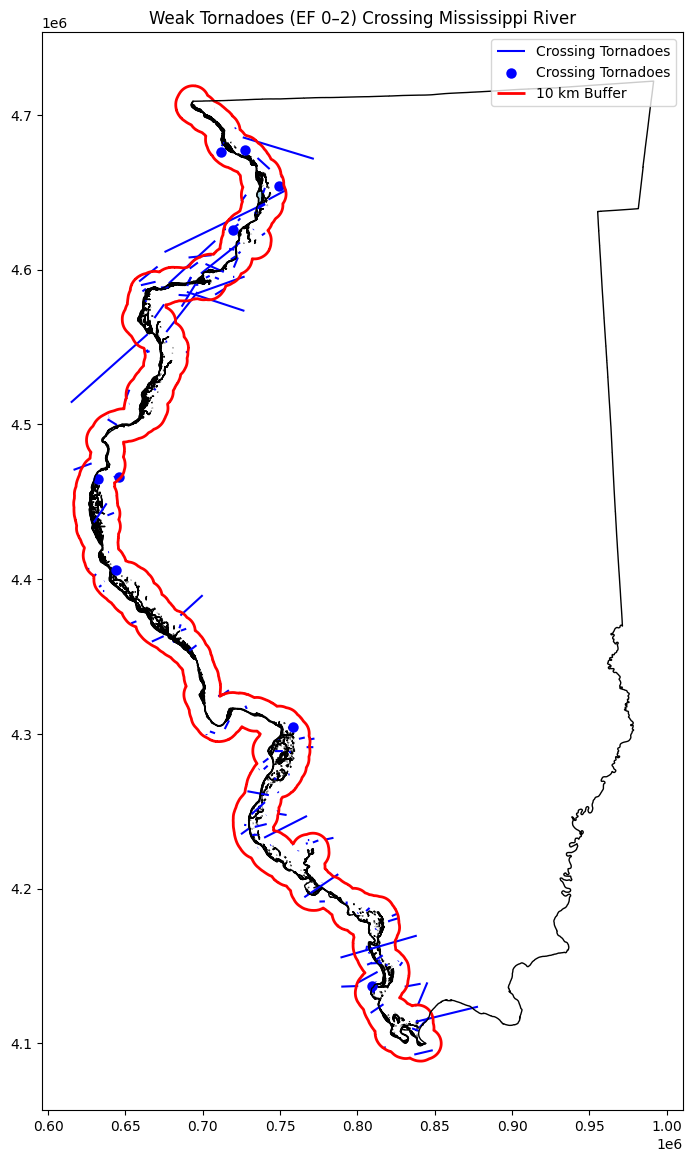

Tornado CRS: EPSG:26915
River CRS: EPSG:26915
River buffer bounds: (616595.5123264829, 4088442.1257714224, 854170.7704540391, 4718927.228456482)


In [18]:
# --- Step 5: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
crossings.plot(ax=ax, color='blue', linewidth=1.5, label='Crossing Tornadoes')
gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')
illinois.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Weak Tornadoes (EF 0–2) Crossing Mississippi River")
ax.legend()
plt.show()

print("Tornado CRS:", tornado_gdf.crs)
print("River CRS:", water_il.crs)
print("River buffer bounds:", river_buffer.bounds)